# Inicio / load

In [4]:
from PIL import Image
import numpy as np
import os
import pandas as pd
import tensorflow as tf

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
ruta_carpeta='/content/drive/MyDrive/DS Taller 2 - images/GitImagenes/dataset/'
train_df=pd.read_csv(f'{ruta_carpeta}/train.txt', header=None, names=['path','fine','coarse'])
val_df=pd.read_csv(f'{ruta_carpeta}/val.txt', header=None, names=['path','fine','coarse'])
test_df=pd.read_csv(f'{ruta_carpeta}/test.txt', header=None, names=['path','fine','coarse'])
clases_df=pd.read_csv(f'{ruta_carpeta}/classes.csv')

#Agregar el path inicial del drive
train_df['path']=train_df['path'].apply(lambda x: ruta_carpeta+x)
val_df['path']=val_df['path'].apply(lambda x: ruta_carpeta+x)
test_df['path']=test_df['path'].apply(lambda x: ruta_carpeta+x)

In [7]:
val_df[val_df['path'].str.contains('mango', case=False, na=False)].shape

(3, 3)

In [ ]:
train_df.head()

,path,fine,coarse
0,/content/drive/MyDrive/DS Taller 2 - images/Gi...,0,0
1,/content/drive/MyDrive/DS Taller 2 - images/Gi...,0,0
2,/content/drive/MyDrive/DS Taller 2 - images/Gi...,0,0
3,/content/drive/MyDrive/DS Taller 2 - images/Gi...,0,0
4,/content/drive/MyDrive/DS Taller 2 - images/Gi...,0,0


In [8]:
coarse_dic=clases_df[['Coarse Class ID (int)','Coarse Class Name (str)']].drop_duplicates().set_index('Coarse Class ID (int)').to_dict(orient='dict')['Coarse Class Name (str)']
fine_dic=clases_df[['Class ID (int)','Class Name (str)']].drop_duplicates().set_index('Class ID (int)').to_dict(orient='dict')['Class Name (str)']

train_df['coarse_str']=train_df['coarse'].map(coarse_dic)
train_df['fine_str']=train_df['fine'].map(fine_dic)

val_df['coarse_str']=val_df['coarse'].map(coarse_dic)
val_df['fine_str']=val_df['fine'].map(fine_dic)

test_df['coarse_str']=test_df['coarse'].map(coarse_dic)
test_df['fine_str']=test_df['fine'].map(fine_dic)

In [10]:
train_df[train_df['path'].str.contains('mango', case=False, na=False)].shape

(32, 5)

In [11]:
print('Train_groups:',len(train_df['fine'].unique()))
print('val_groups:',len(val_df['fine'].unique()))
print('Test_groups:',len(test_df['fine'].unique()))

Train_groups: 81
val_groups: 60
Test_groups: 81


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalización
    rotation_range=20,           # Rotación aleatoria
    width_shift_range=0.2,       # Traslación horizontal
    height_shift_range=0.2,      # Traslación vertical
    shear_range=0.2,             # Cizallamiento
    zoom_range=0.2,              # Zoom
    horizontal_flip=True,        # Inversión horizontal
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(rescale=1./255)

# Cargar las imágenes en lotes (batch)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',         # Nombre de la columna de rutas de imágenes
    y_col='coarse_str',               # Nombre de la columna de etiquetas
    target_size=(224, 224),      # Tamaño de las imágenes
    batch_size=32,
    class_mode='categorical'     # Clasificación categórica
)

validation_generator = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',         # Nombre de la columna de rutas de imágenes
    y_col='coarse_str',               # Nombre de la columna de etiquetas
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# The 'class_indices' attribute becomes available after calling flow_from_dataframe.
# So, move the following lines after creating validation_generator
train_classes = set(train_generator.class_indices.keys())
val_classes = set(validation_generator.class_indices.keys()) # Access class_indices from validation_generator

# Find missing classes in validation and add empty classes if needed
missing_classes = train_classes - val_classes
if missing_classes:
    print(f"Warning: Missing classes in validation: {missing_classes}")
    for missing_class in missing_classes:
        validation_generator.class_indices[missing_class] = len(validation_generator.class_indices) # Update validation_generator's class_indices
    print(f"Updated validation classes: {validation_generator.class_indices}")

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_classes), activation='softmax')  # Output layer for 43 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Save the model
model.save('cnn_model.h5')

# Evaluate the model
results = model.evaluate(validation_generator)
print(f"Validation Accuracy: {results[1] * 100:.2f}%")


KeyboardInterrupt: 

# Preparar las imagenes

In [15]:
#Preparar las imagenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configura la aumentación de datos y normalización
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalización
    rotation_range=20,           # Rotación aleatoria
    width_shift_range=0.2,       # Traslación horizontal
    height_shift_range=0.2,      # Traslación vertical
    shear_range=0.2,             # Cizallamiento
    zoom_range=0.2,              # Zoom
    horizontal_flip=True,        # Inversión horizontal
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Cargar las imágenes en lotes (batch)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',         # Nombre de la columna de rutas de imágenes
    y_col='coarse_str',               # Nombre de la columna de etiquetas
    target_size=(224, 224),      # Tamaño de las imágenes
    batch_size=32,
    class_mode='categorical'     # Clasificación categórica
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',         # Nombre de la columna de rutas de imágenes
    y_col='coarse_str',               # Nombre de la columna de etiquetas
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_classes = val_df['coarse_str'].unique()
train_df_filtered = train_df[train_df['coarse_str'].isin(val_classes)]

train_generator_filtered = train_datagen.flow_from_dataframe(
    dataframe=train_df_filtered,  # Usa el DataFrame filtrado
    x_col='path',
    y_col='coarse_str',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2640 validated image filenames belonging to 43 classes.
Found 296 validated image filenames belonging to 37 classes.
Found 2446 validated image filenames belonging to 37 classes.


In [ ]:
# The 'class_indices' attribute becomes available after calling flow_from_dataframe.
# So, move the following lines after creating validation_generator
#train_classes = set(train_generator.class_indices.keys())
#val_classes = set(validation_generator.class_indices.keys()) # Access class_indices from validation_generator

# Find missing classes in validation and add empty classes if needed
#missing_classes = train_classes - val_classes
#if missing_classes:
 #   print(f"Warning: Missing classes in validation: {missing_classes}")
  #  for missing_class in missing_classes:
   #     validation_generator.class_indices[missing_class] = len(validation_generator.class_indices) # Update validation_generator's class_indices
    #print(f"Updated validation classes: {validation_generator.class_indices}")


Updated validation classes: {'Apple': 0, 'Asparagus': 1, 'Aubergine': 2, 'Avocado': 3, 'Banana': 4, 'Cabbage': 5, 'Carrots': 6, 'Cucumber': 7, 'Ginger': 8, 'Juice': 9, 'Kiwi': 10, 'Leek': 11, 'Lemon': 12, 'Lime': 13, 'Mango': 14, 'Melon': 15, 'Milk': 16, 'Mushroom': 17, 'Oat-Milk': 18, 'Oatghurt': 19, 'Onion': 20, 'Orange': 21, 'Passion-Fruit': 22, 'Peach': 23, 'Pear': 24, 'Pepper': 25, 'Pineapple': 26, 'Pomegranate': 27, 'Potato': 28, 'Red-Beet': 29, 'Red-Grapefruit': 30, 'Satsumas': 31, 'Sour-Cream': 32, 'Soyghurt': 33, 'Tomato': 34, 'Yoghurt': 35, 'Zucchini': 36, 'Papaya': 37, 'Sour-Milk': 38, 'Nectarine': 39, 'Soy-Milk': 40, 'Plum': 41, 'Garlic': 42}


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available:  1
GPU Available: True


# Modelo inicial


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_size = (224, 224)
batch_size = 32
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(37, activation='softmax')  # Output layer for 43 classes
])



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Instead of hardcoding, dynamically get the number of classes from the generator
num_classes = len(train_generator_filtered.class_indices)
# Assuming your generator was created with flow_from_directory
# and has the 'class_indices' attribute

# Load the pre-trained base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom output layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Ensure the final Dense layer has the correct number of units
predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers of the base model to prevent retraining
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [20]:
# Compilación
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configura Early Stopping y el guardado del mejor modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator_filtered,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 1021s 12s/step - accuracy: 0.1099 - loss: 3.7741 - val_accuracy: 0.1622 - val_loss: 3.0084
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.2042 - loss: 2.8520 - val_accuracy: 0.2736 - val_loss: 2.8461
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 492ms/step - accuracy: 0.2669 - loss: 2.6045 - val_accuracy: 0.3108 - val_loss: 2.5486
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 43s 508ms/step - accuracy: 0.2896 - loss: 2.3820 - val_accuracy: 0.2736 - val_loss: 2.4059
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - accuracy: 0.3378 - loss: 2.2320 - val_accuracy: 0.2872 - val_loss: 2.3109
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 81s 471ms/step - accuracy: 0.4016 - loss: 2.0412 - val_accuracy: 0.3209 - val_loss: 2.2808
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 473ms/step - accuracy: 0.4173 - loss: 1.9437 - val_accuracy: 0.3716 - val_loss: 2.0421
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 82s 494ms/step - accuracy: 0.4225 - loss: 1.8407 - val_accuracy: 0.358

# Metricas


In [ ]:
# Evaluar en el conjunto de validación
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Accuracy en validación: {val_accuracy:.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.5431 - loss: 1.4833
Accuracy en validación: 0.52


In [ ]:
model.save('/content/drive/MyDrive/DS Taller 2 - images/cnn_model.keras')

Load model

In [17]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/DS Taller 2 - images/cnn_model.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


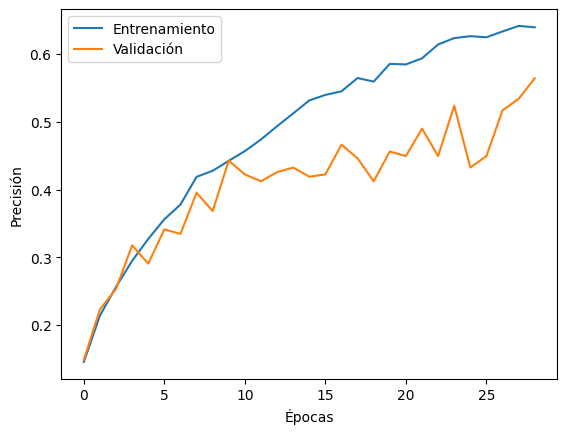

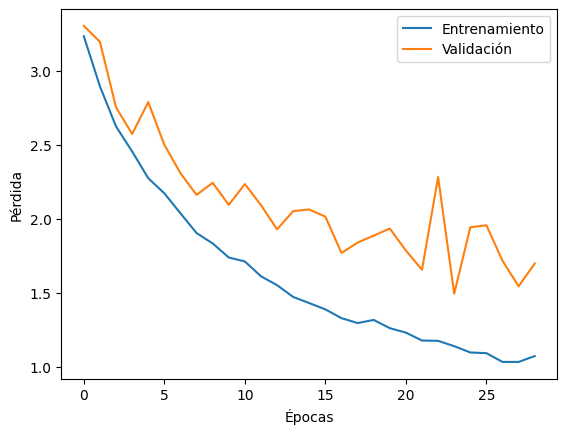

In [ ]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
# Mostrar 5 imágenes correctas
print("Correctly Classified Images:")
for i, idx in enumerate(correct_indices[:5]):
    img, label = test_generator[idx]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img[0])
    plt.title(f"Pred: {class_names[predicted_labels[idx]]}\nTrue: {class_names[true_labels[idx]]}")
    plt.axis('off')
plt.show()

# Mostrar 5 imágenes incorrectas
print("Incorrectly Classified Images:")
for i, idx in enumerate(incorrect_indices[:5]):
    img, label = test_generator[idx]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img[0])
    plt.title(f"Pred: {class_names[predicted_labels[idx]]}\nTrue: {class_names[true_labels[idx]]}")
    plt.axis('off')
plt.show()

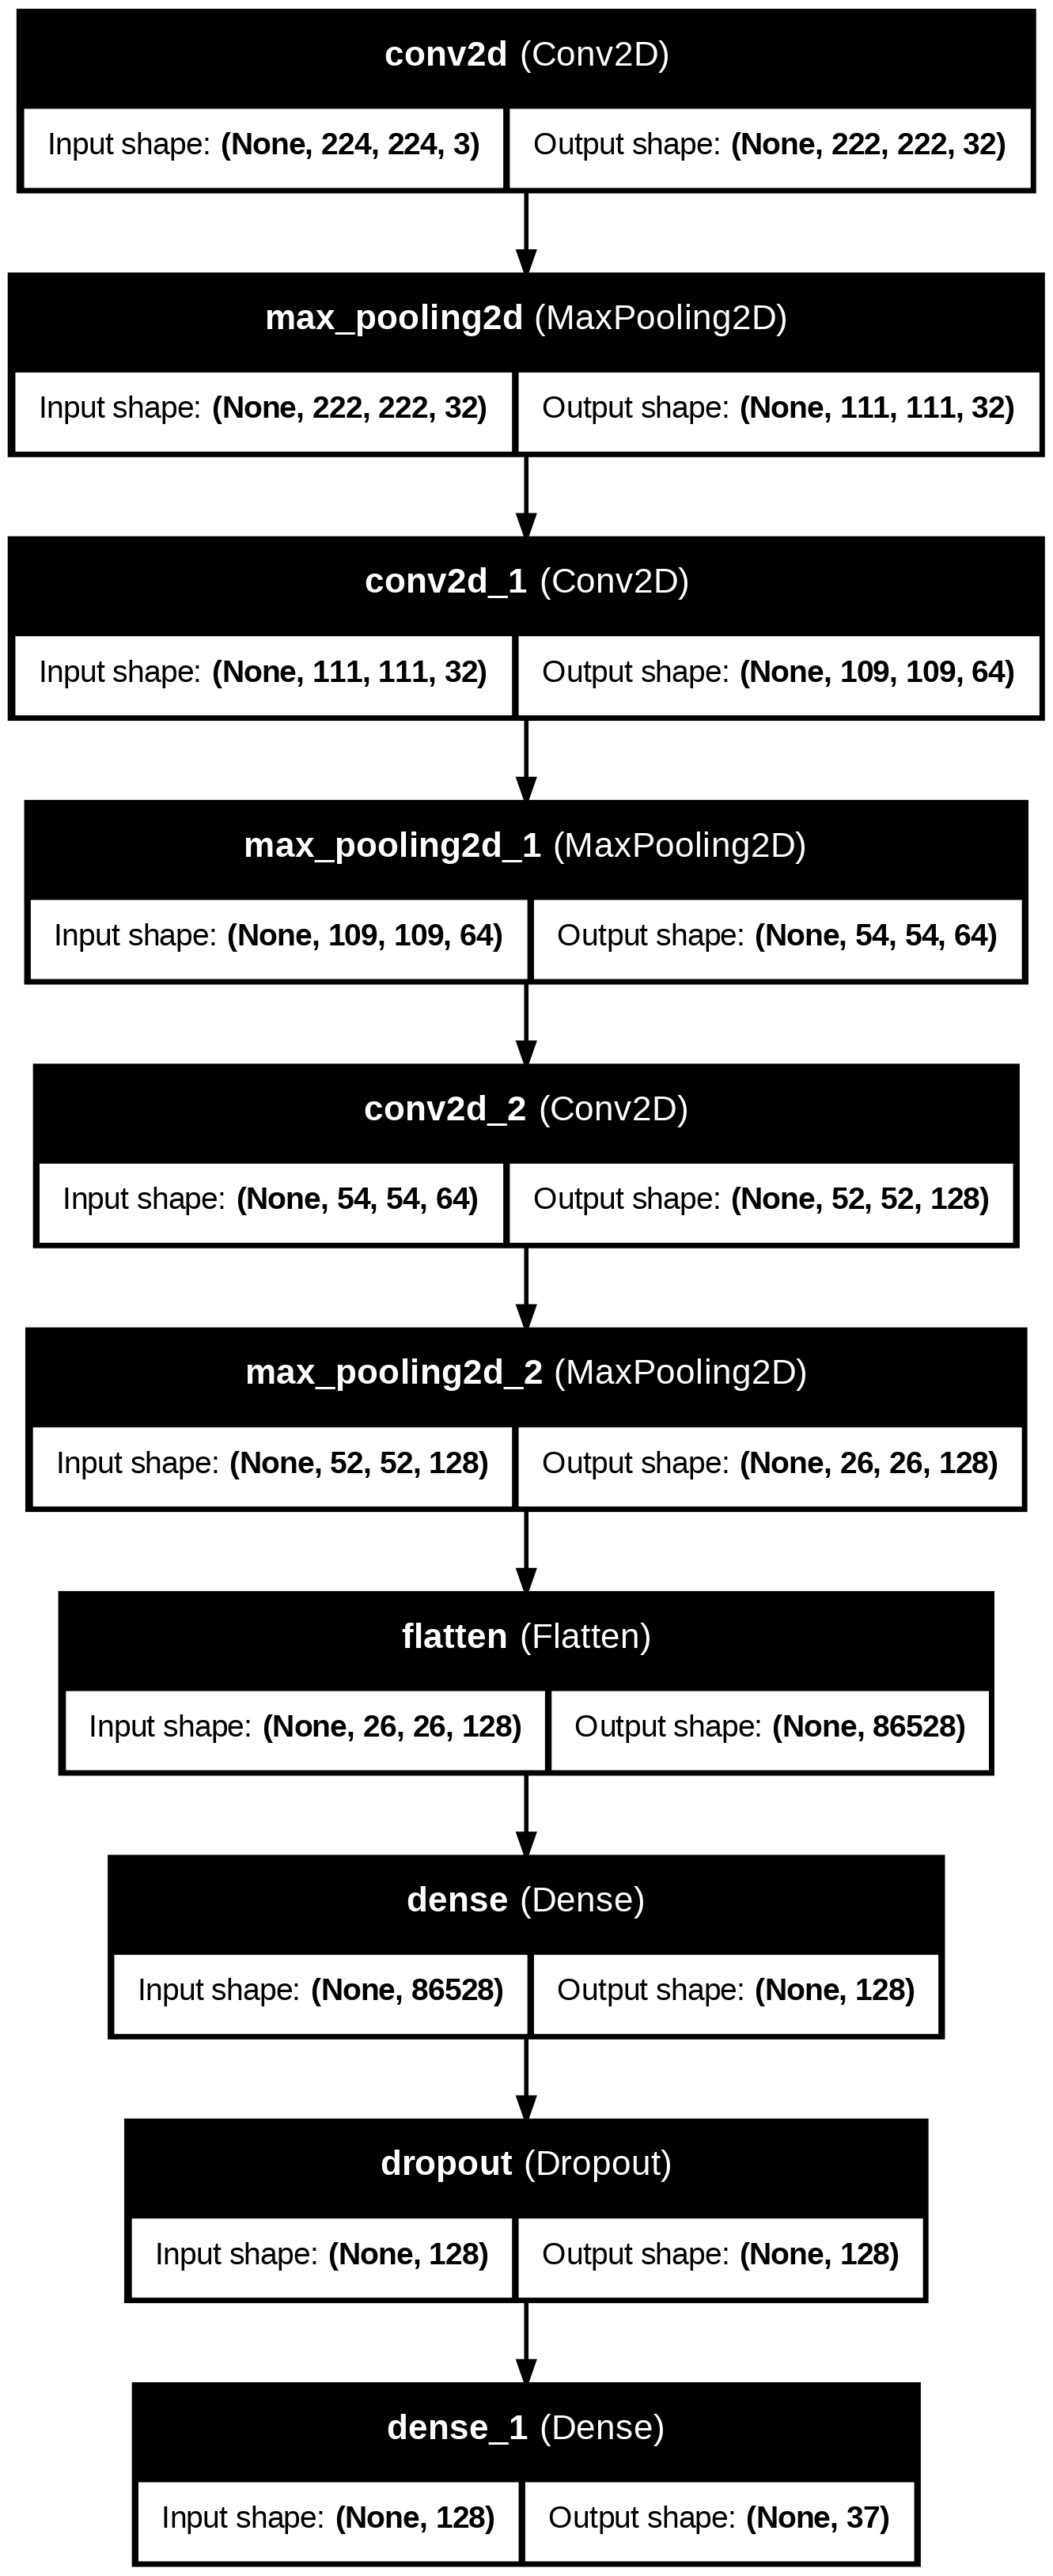

In [18]:
from tensorflow.keras.utils import plot_model

# Generar y guardar el gráfico del modelo
plot_model(loaded_model, to_file='model_topology.png', show_shapes=True, show_layer_names=True)

# Si estás en un entorno de Jupyter o Colab, puedes mostrar la imagen directamente
from IPython.display import Image
Image('model_topology.png')
